### Improving Semantic Water Segmentation by Fusing Sentinel-1 Intensity and Interferometric Synthetic Aperture Radar
### (InSAR) Coherence Data

**Author: Ernesto Colon**
**The Cooper Union for the Advancement of Science and Art**

#### Attention U-Net Model Inference

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import metrics_utils
from utils import dataset_gen
from utils import general_utils
import time
import tensorflow as tf
from keras_unet_collection import models

Load previously saved dataset splits

In [2]:
# Define dictionary with filepaths
base_dir = "base_dir_path"

train_val_test_pths = {'train_fn_df' : f"{base_dir}\\ds_train_split_10m.csv",
                       'val_fn_df' : f"{base_dir}\\ds_val_split_10m.csv",
                       'test_fn_df' : f"{base_dir}\\ds_test_split_10m.csv"}

# Load csv files with train / val / test splits into dataframes
train_val_fn_df, test_fn_df, train_size, val_size, test_size =\
    dataset_gen.unet_load_ds_df(train_val_test_pths['train_fn_df'],
                                train_val_test_pths['val_fn_df'],
                                train_val_test_pths['test_fn_df'])

Define category names and a color mapping for semantic segmentation

In [3]:
# Define category names
tgt_cat_names = {
    0: 'Not water',
    1: 'Water'
}

# Define the colors per category
wtr_clrs_hex = ['#f7f7f7', '#67a9cf']

# Generate the labels colormap
wtr_cmap = general_utils.gen_cmap(wtr_clrs_hex)

### Generate data sets for inference

We generate datasets for the following scenarios:

- Scenario 1: Co-event intensity data only
- Scenario 2: Pre- and co-event intensity data only
- Scenario 3: Pre- and co-event intensity and coherence data

In [6]:
# Define dictionaries to hold the datasets - the keys will be the different scenarios
X_train_dict = {}
Y_train_dict = {}

X_val_dict = {}
Y_val_dict = {}

X_test_dict = {}
Y_test_dict = {}

Y_pred_dict = {}

# Define scenario number to scenario name mapping
scenario_dict = {1: 'co_event_intensity_only',
                 2: 'pre_co_event_intensity',
                 3: 'pre_co_event_int_coh'}

scenario_num_bands = {1: 2,
                      2: 4,
                      3: 6}

# Define the number of bands per scenario
num_bands_dict = {'co_event_intensity_only': 2,
                 'pre_co_event_intensity': 4,
                 'pre_co_event_int_coh': 6}

IMG_SIZE = 512

# define dictionaries to hold the datasets
train_val_samples_dict = {}
test_samples_dict = {}

# Loop through each scenario and create the tensorflow data loaders
scenarios = [1, 2, 3]

for scenario in scenarios:

    # Create the samples list given the dataframes with file paths as input
    train_val_samples_dict[f"scenario_{scenario}"], test_samples_dict[f"scenario_{scenario}"] = \
        dataset_gen.create_samples_list({'scenario': scenario_dict[scenario],
                                            'test_df': test_fn_df,
                                            'train_val_df': train_val_fn_df})

    # Create data sets dictionary
    X_train_dict[f"scenario_{scenario}"], X_val_dict[f"scenario_{scenario}"], X_test_dict[f"scenario_{scenario}"] =\
        dataset_gen.unet_ds_creation({'train_val_list': train_val_samples_dict[f"scenario_{scenario}"],
                                      'test_list': test_samples_dict[f"scenario_{scenario}"]})

    # Batch the tensorflow train, val, and test data set generators
    X_train_dict[f"scenario_{scenario}"] =\
        X_train_dict[f"scenario_{scenario}"].batch(10).prefetch(tf.data.experimental.AUTOTUNE)

    X_val_dict[f"scenario_{scenario}"] =\
        X_val_dict[f"scenario_{scenario}"].batch(10).prefetch(tf.data.experimental.AUTOTUNE)

    X_test_dict[f"scenario_{scenario}"] = X_test_dict[f"scenario_{scenario}"].batch(1)


#### Hand Labeled Dataset

In [7]:
# load hand label dataset
hand_lbl_ds_pth = "hand_lbl_ds_pth"
hand_lbl_ds_fname = f"{hand_lbl_ds_pth}hand_lbl_ds_10m_res.csv"

df_hand_lbl_samples = pd.read_csv(hand_lbl_ds_fname)

# loop through df and append sample paths to a list
hand_samples = list()

for idx, row in df_hand_lbl_samples.iterrows():
    hand_samples.append((row['s1'], row['pre_event_grd'], row['pre_event_coh'], row['co_event_coh'], row['hand_lbl']))


hand_lbl_test_samples = dict()

for scenario in scenarios:
    hand_lbl_test_samples[f"scenario_{scenario}_hand_lbl"] =\
        dataset_gen.create_samples_list_hand_lbl({'scenario': scenario_dict[scenario], 'test_df': df_hand_lbl_samples})

    X_test_dict[f"scenario_{scenario}_hand_lbl"] =\
        dataset_gen.ds_creation_hand_lbl({'test_list': hand_lbl_test_samples[f"scenario_{scenario}_hand_lbl"]})

    X_test_dict[f"scenario_{scenario}_hand_lbl"] = X_test_dict[f"scenario_{scenario}_hand_lbl"].batch(1)

#### Attention U-Net Models

For this study, we leverage the publicly available Keras UNet Collection linked below.

https://github.com/yingkaisha/keras-unet-collection

**Load previously saved model weights**

In [9]:
IMG_SIZE = 512

attn_unet_models_dir = {'scenario_1': "model_scen_1_weights_pth",
                        'scenario_2': "model_scen_2_weights_pth",
                        'scenario_3': "model_scen_3_weights_pth"}

attn_unet_models_dict = dict()

for scenario in scenarios:
    attn_unet_models_dict[f"scenario_{scenario}"] =\
        models.att_unet_2d((IMG_SIZE, IMG_SIZE, scenario_num_bands[scenario]),
                           filter_num=[64, 128, 256, 512, 1024],
                           n_labels=2,
                           stack_num_down=2,
                           stack_num_up=2,
                           activation='ReLU',
                           atten_activation='ReLU',
                           attention='add',
                           output_activation='Sigmoid',
                           batch_norm=True,
                           pool=False,
                           unpool=False,
                           backbone='VGG16',
                           weights=None,
                           freeze_backbone=True,
                           freeze_batch_norm=True,
                           name='attunet')

    # restore the weights
    print(f"Loading weights for scenario: {scenario}...\n")
    attn_unet_models_dict[f"scenario_{scenario}"].load_weights(attn_unet_models_dir[f"scenario_{scenario}"])

C:\Users\ernes\anaconda3\envs\tf_rs\lib\site-packages\keras_unet_collection\_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


Loading weights for scenario: 1...

Loading weights for scenario: 2...

Loading weights for scenario: 3...



### Make predictions

In [10]:
# wrapping the predictions routine into a function
def u_net_inference(x_test_ds, test_size, model):
    """
    Function to make inferences using tensorflow

    :param x_test_ds: tensorflow dataset pipeline for testing
    :param test_size: number of test images in our pipeline
    :param model: tensorflow model for inference
    :return: y_test and y_pred are ndarrays with shape (num_pix,)
    """

    start_time = time.time()

    # Compute predictions at the same time to avoid a random shift
    test_tgts_list = []
    pred_tgts_list = []

    for img, tgt, weights in x_test_ds.take(test_size):
        pred = metrics_utils.create_mask(model.predict(img))
        pred_tgts_list.append(np.squeeze(pred))

        test_tgts_list.append(np.squeeze(tgt.numpy()))

    y_test = np.stack(test_tgts_list, axis=-1).flatten()
    y_pred = np.stack(pred_tgts_list, axis=-1).flatten()

    print(f"Inference took: {time.time() - start_time} seconds\n")

    return y_test, y_pred

**Predicting on held-out test set and hand-labeled test set**

**Notes**

The held-out test set is comprised of Sentinel-2 weak labels from the Sen1Floods11 data set.

The hand-labeled data set is also provided by the Sen1Floods11 data set, and provides an independent data set not
used during training.

In [11]:
start_time = time.time()

# loop through each scenario
for scenario in scenarios:

    # Held-out dataset predictions
    print(f"Predicting on held-out test dataset for scenario: {scenario}...\n")
    Y_test_dict[f"scenario_{scenario}"], Y_pred_dict[f"scenario_{scenario}"] =\
        u_net_inference(X_test_dict[f"scenario_{scenario}"],
                        test_size,
                        attn_unet_models_dict[f"scenario_{scenario}"])

    # Hand-labeled dataset predictions
    print(f"Predicting on hand-labeled test dataset for scenario: {scenario}...\n")
    Y_test_dict[f"scenario_{scenario}_hand_lbl"], Y_pred_dict[f"scenario_{scenario}_hand_lbl"] =\
        u_net_inference(X_test_dict[f"scenario_{scenario}_hand_lbl"],
                        test_size,
                        attn_unet_models_dict[f"scenario_{scenario}"])

print(f"\n\nTotal inference took: {time.time() - start_time} seconds")

Predicting on held-out test dataset for scenario: 1...

Inference took: 46.43437170982361 seconds

Predicting on hand-labeled test dataset for scenario: 1...

Inference took: 16.274906873703003 seconds

Predicting on held-out test dataset for scenario: 2...

Inference took: 39.749754667282104 seconds

Predicting on hand-labeled test dataset for scenario: 2...

Inference took: 18.790385723114014 seconds

Predicting on held-out test dataset for scenario: 3...

Inference took: 44.10836148262024 seconds

Predicting on hand-labeled test dataset for scenario: 3...

Inference took: 19.12611961364746 seconds



Total inference took: 184.62442350387573 seconds


### Compute Metrics

For metrics, we compute:

- Overall accuracy
- Mean intersection over union, mIoU
- Jaccard score
- Water precision
- Water recall
- Water f1-score
- Not-Water precision
- Not-Water recall
- Not-Water f1-score

#### Held-out Test Dataset

In [12]:
start_time = time.time()

summary_df = metrics_utils.summary_report(Y_test_dict, Y_pred_dict)

print(f"\n\nProcess took: {time.time() - start_time} seconds")

# save summary to csv file
attn_unet_summ_pth = "attn_unet_summ_pth"
fname = "attn_unet_10m_summary_stats.csv"
summary_df.to_csv(f"{attn_unet_summ_pth}\\{fname}")

                    scenario_1 scenario_1_hand_lbl scenario_2  \
Overall Accuracy      0.938335            0.952914   0.936505   
Mean IoU              0.661096            0.702943   0.644988   
Jaccard Score         0.629297            0.545741   0.603337   
Water Precision       0.776582            0.866256   0.802011   
Water Recall          0.768415            0.595956   0.708927   
Water f1-score        0.772477            0.706122   0.752602   
Not Water Precision   0.963536            0.958968   0.954918   
Not Water Recall      0.965134             0.99035   0.972398   
Not Water f1-score    0.964334            0.974407   0.963579   

                    scenario_2_hand_lbl scenario_3 scenario_3_hand_lbl  
Overall Accuracy               0.949417   0.939358            0.955799  
Mean IoU                       0.676986   0.666043            0.723068  
Jaccard Score                  0.502667   0.635641            0.578556  
Water Precision                0.882805   0.777905       

#### Computing IoU per class (i.e., water and not-water)

In [13]:
miou_per_class = metrics_utils.miou_per_class(Y_test_dict, Y_pred_dict)

# save to csv file
mIou_fname = "attn_unet_10m_mIoU_per_class_stats.csv"
miou_per_class.to_csv(f"{attn_unet_summ_pth}\\{mIou_fname}")

               scenario_1 scenario_1_hand_lbl scenario_2 scenario_2_hand_lbl  \
Total mIoU       0.661096            0.702943   0.644988            0.676986   
Not Water mIoU   0.692896            0.860145    0.68664            0.851304   
Water mIoU       0.629297            0.545741   0.603337            0.502667   

               scenario_3 scenario_3_hand_lbl  
Total mIoU       0.666043            0.723068  
Not Water mIoU   0.696445            0.867579  
Water mIoU       0.635641            0.578556  


### Testing Models' Ability to Generalize

We use data over the Sri-Lanka region (both weakly labeled and hand-labeled) to test the models' ability
to generalize

#### Generate generalization data set

In [14]:
generalization_ds_pth = "generalization_ds_pth"

# create empty list to store the samples' path
gen_test_samples = []

# load csv file into dataframe
gen_test_fn_df = pd.read_csv(generalization_ds_pth)

# grab number of samples in the data set
num_gen_samp = len(gen_test_samples)

# create dictionaries to store the tensorflow data loaders
gener_test_samples = {}

gener_X_test_dict = dict()
gener_Y_test_dict = dict()


for scenario in scenarios:
    gener_test_samples[f"scenario_{scenario}"] =\
        dataset_gen.create_samples_list_hand_lbl({'scenario': scenario_dict[scenario], 'test_df': gen_test_fn_df})

    gener_X_test_dict[f"scenario_{scenario}"] =\
        dataset_gen.ds_creation_hand_lbl({'test_list': gener_test_samples[f"scenario_{scenario}"]})

    gener_X_test_dict[f"scenario_{scenario}"] = gener_X_test_dict[f"scenario_{scenario}"].batch(1)


#### Hand-Labeled Generalization Data Set

In [15]:
# load hand-labeled dataset
gen_hand_lbl_ds_pth = "gen_hand_lbl_ds_pth"

# read hand-labeled data set into dataframe
gen_hand_lbl_df = pd.read_csv(gen_hand_lbl_ds_pth)

# create dict to store tensorflow data loaders
gen_hand_samples_by_region_dict = {}

# loop through each scenario and create the tensorflow dat loaders
for scenario in scenarios:
    gener_test_samples[f"scenario_{scenario}_hand_lbl"] =\
        dataset_gen.create_samples_list_hand_lbl({'scenario': scenario_dict[scenario],'test_df': gen_hand_lbl_df})

    gener_X_test_dict[f"scenario_{scenario}_hand_lbl"] = dataset_gen.ds_creation_hand_lbl({'test_list': gener_test_samples[f"scenario_{scenario}_hand_lbl"]})
    gener_X_test_dict[f"scenario_{scenario}_hand_lbl"] = gener_X_test_dict[f"scenario_{scenario}_hand_lbl"].batch(1)

# grab the generalization data set's size
gener_hand_lbl_test_size = gen_hand_lbl_df.shape[0]

#### Make Predictions on the Generalization Data Set

In [16]:
# create dictionary to store the generalization data set's predictions
gener_Y_pred_dict = dict()

# Keep track of how long inference takes
start_time = time.time()

for scenario in scenarios:

    # Held-out dataset predictions
    print(f"Predicting on held-out test dataset for scenario: {scenario}...\n")
    gener_Y_test_dict[f"scenario_{scenario}"], gener_Y_pred_dict[f"scenario_{scenario}"] =\
        u_net_inference(gener_X_test_dict[f"scenario_{scenario}"],
                        gener_hand_lbl_test_size,
                        attn_unet_models_dict[f"scenario_{scenario}"])

    # Hand-labeled dataset predictions
    print(f"Predicting on hand-labeled test dataset for scenario: {scenario}...\n")
    gener_Y_test_dict[f"scenario_{scenario}_hand_lbl"], gener_Y_pred_dict[f"scenario_{scenario}_hand_lbl"] =\
        u_net_inference(gener_X_test_dict[f"scenario_{scenario}_hand_lbl"],
                        gener_hand_lbl_test_size,
                        attn_unet_models_dict[f"scenario_{scenario}"])

print(f"\n\nTotal inference took: {time.time() - start_time} seconds")

Predicting on held-out test dataset for scenario: 1...

Inference took: 3.7535808086395264 seconds

Predicting on hand-labeled test dataset for scenario: 1...

Inference took: 3.139770746231079 seconds

Predicting on held-out test dataset for scenario: 2...

Inference took: 3.9556069374084473 seconds

Predicting on hand-labeled test dataset for scenario: 2...

Inference took: 3.5592126846313477 seconds

Predicting on held-out test dataset for scenario: 3...

Inference took: 4.576826095581055 seconds

Predicting on hand-labeled test dataset for scenario: 3...

Inference took: 3.7382285594940186 seconds



Total inference took: 22.739170789718628 seconds


### Compute Metrics for Generalization Data Set

In [17]:
stat_time = time.time()

# Generate metrics
gener_summary_df = metrics_utils.summary_report(gener_Y_test_dict, gener_Y_pred_dict)

print(f"\n\nProcess took: {time.time() - start_time} seconds")

# save the metrics to a csv file for later recall
gener_summ_fname = "attn_unet_10m_generalization_stats.csv"
gener_summary_df.to_csv(f"{attn_unet_summ_pth}\\{gener_summ_fname}")

                    scenario_1 scenario_1_hand_lbl scenario_2  \
Overall Accuracy      0.877403            0.892024   0.886417   
Mean IoU              0.450286            0.451395   0.499065   
Jaccard Score         0.023531            0.010894   0.113387   
Water Precision        0.69521            0.855098   0.790364   
Water Recall          0.023776            0.010914   0.116903   
Water f1-score         0.04598            0.021553    0.20368   
Not Water Precision   0.878181            0.892075   0.888216   
Not Water Recall      0.998521            0.999774     0.9956   
Not Water f1-score    0.934493            0.942859   0.938847   

                    scenario_2_hand_lbl scenario_3 scenario_3_hand_lbl  
Overall Accuracy                0.90572   0.918014            0.932536  
Mean IoU                       0.520436   0.668538            0.662184  
Jaccard Score                  0.136579   0.424336            0.394939  
Water Precision                0.984873    0.76889       

#### Compute IoU per class for generalization dataset

In [18]:
gener_miou_per_class = metrics_utils.miou_per_class(gener_Y_test_dict, gener_Y_pred_dict)

# save to csv
gener_miou_fname = "attn_unet_10m_generalization_mIoU_stats.csv"
gener_miou_per_class.to_csv(f"{attn_unet_summ_pth}\\{gener_miou_fname}")

               scenario_1 scenario_1_hand_lbl scenario_2 scenario_2_hand_lbl  \
Total mIoU       0.450286            0.451395   0.499065            0.520436   
Not Water mIoU    0.87704            0.891895   0.884743            0.904293   
Water mIoU       0.023531            0.010894   0.113387            0.136579   

               scenario_3 scenario_3_hand_lbl  
Total mIoU       0.668538            0.662184  
Not Water mIoU    0.91274            0.929429  
Water mIoU       0.424336            0.394939  


#### Making Inferences Aggregated by Geographical Region

In [19]:
for scenario in scenarios:
    gener_test_samples[f"scenario_{scenario}"] =\
        dataset_gen.create_samples_list_hand_lbl({'scenario': scenario_dict[scenario], 'test_df': gen_test_fn_df})

    gener_X_test_dict[f"scenario_{scenario}"] =\
        dataset_gen.ds_creation_hand_lbl({'test_list': gener_test_samples[f"scenario_{scenario}"]})

    gener_X_test_dict[f"scenario_{scenario}"] = gener_X_test_dict[f"scenario_{scenario}"].batch(1)

In [20]:
test_samples_by_region_dict = {}

# Define the regions excluding the generalization region
regions = ['USA', 'Mekong', 'Colombia', 'Paraguay', 'India', 'Bolivia']

# create dictionary schema to hold the tensorflow data loaders aggregated by region
X_test_ds_region_dict = {region: {} for region in regions}

ds_test_size_region = {}

# loop through each of the regions
for region in regions:
    # temp list to store the file paths
    pths = list()

    # pluck the test sample paths by region
    test_pth_region = test_fn_df[test_fn_df.s1.str.contains(region)]

    ds_test_size_region[region] = test_pth_region.shape[0]

    for scenario in scenarios:
        region_test_samples = dataset_gen.create_samples_list_hand_lbl({'scenario': scenario_dict[scenario],
                             'test_df': test_pth_region})

        X_test_ds_region_dict[region][f"scenario_{scenario}"] =\
            dataset_gen.ds_creation_hand_lbl({'test_list': region_test_samples})

        X_test_ds_region_dict[region][f"scenario_{scenario}"] =\
            X_test_ds_region_dict[region][f"scenario_{scenario}"].batch(1)


# Hand-labeled data set aggregated by region
hand_lbl_ds_test_size_region = {}

for region in regions:
    # temp list to store the file paths
    pths = list()

    # pluck the test sample paths by region
    test_pth_region = df_hand_lbl_samples[df_hand_lbl_samples.s1.str.contains(region)]

    hand_lbl_ds_test_size_region[region] = test_pth_region.shape[0]

    for scenario in scenarios:
        region_test_samples = dataset_gen.create_samples_list_hand_lbl({'scenario': scenario_dict[scenario],
                             'test_df': test_pth_region})

        X_test_ds_region_dict[region][f"scenario_{scenario}_hand_lbl"] =\
            dataset_gen.ds_creation_hand_lbl({'test_list': region_test_samples})

        X_test_ds_region_dict[region][f"scenario_{scenario}_hand_lbl"] =\
            X_test_ds_region_dict[region][f"scenario_{scenario}_hand_lbl"].batch(1)


Compute inferences aggregated by region

In [21]:
# create dicts to store predictions and ground truth
Y_pred_region_dict = {region : {} for region in regions}
Y_test_region_dict = {region : {} for region in regions}

start_time = time.time()

for region in regions:
    for scenario in scenarios:

        # Held-out dataset predictions
        print(f"Predicting on held-out test dataset for region: {region}, scenario: {scenario}...\n")
        Y_test_region_dict[region][f"scenario_{scenario}"], Y_pred_region_dict[region][f"scenario_{scenario}"] =\
            u_net_inference(X_test_ds_region_dict[region][f"scenario_{scenario}"],
                            ds_test_size_region[region],
                            attn_unet_models_dict[f"scenario_{scenario}"])

        # Hand-labeled dataset predictions
        if region == 'Colombia':
            continue    # The Sen1Floods11 data set does not have hand-labels for Colombia
        else:
            print(f"Predicting on hand-labeled test dataset for region:{region}, scenario: {scenario}...\n")
            Y_test_region_dict[region][f"scenario_{scenario}_hand_lbl"],\
            Y_pred_region_dict[region][f"scenario_{scenario}_hand_lbl"] =\
                u_net_inference(X_test_ds_region_dict[region][f"scenario_{scenario}_hand_lbl"],
                                hand_lbl_ds_test_size_region[region],
                                attn_unet_models_dict[f"scenario_{scenario}"])

print(f"\n\nTotal inference took: {time.time() - start_time} seconds")

Predicting on held-out test dataset for region: USA, scenario: 1...

Inference took: 6.526680946350098 seconds

Predicting on hand-labeled test dataset for region:USA, scenario: 1...

Inference took: 4.513045787811279 seconds

Predicting on held-out test dataset for region: USA, scenario: 2...

Inference took: 6.413188695907593 seconds

Predicting on hand-labeled test dataset for region:USA, scenario: 2...

Inference took: 5.055190324783325 seconds

Predicting on held-out test dataset for region: USA, scenario: 3...

Inference took: 7.17697811126709 seconds

Predicting on hand-labeled test dataset for region:USA, scenario: 3...

Inference took: 5.264311075210571 seconds

Predicting on held-out test dataset for region: Mekong, scenario: 1...

Inference took: 14.647160530090332 seconds

Predicting on hand-labeled test dataset for region:Mekong, scenario: 1...

Inference took: 2.115988254547119 seconds

Predicting on held-out test dataset for region: Mekong, scenario: 2...

Inference took

#### Generate prediction summaries / metrics by region

In [22]:
start_time = time.time()

summary_by_region = {}

for region in regions:
    print(f"Region: {region}\n\n")
    summary_by_region[region] = metrics_utils.summary_report(Y_test_region_dict[region], Y_pred_region_dict[region])
    print("\n\n")

    # save to csv
    summary_by_region[region].to_csv(f"{attn_unet_summ_pth}\\{region}_summary_stats.csv")

print(f"\n\nProcess took: {time.time() - start_time} seconds")

Region: USA


                    scenario_1 scenario_1_hand_lbl scenario_2  \
Overall Accuracy      0.976146            0.974289   0.975448   
Mean IoU              0.741963            0.744334   0.726698   
Jaccard Score         0.511473            0.515101   0.481725   
Water Precision       0.843653            0.804867   0.877944   
Water Recall           0.56503            0.588607   0.516303   
Water f1-score        0.676787            0.679956   0.650222   
Not Water Precision   0.980188             0.98024    0.97805   
Not Water Recall      0.995158            0.993056   0.996681   
Not Water f1-score    0.987616            0.986606   0.987277   

                    scenario_2_hand_lbl scenario_3 scenario_3_hand_lbl  
Overall Accuracy               0.975531   0.977564            0.977851  
Mean IoU                       0.744599   0.756552            0.774666  
Jaccard Score                  0.514318   0.539055            0.572157  
Water Precision                0.866879   0

#### Compute IoU per class aggregated by region

In [23]:
regional_miou_per_class = {}

for region in regions:
    print(f"Region: {region}\n\n")

    regional_miou_per_class[region] =\
        metrics_utils.miou_per_class(Y_test_region_dict[region], Y_pred_region_dict[region])

    print("\n\n")

    # save to csv
    regional_miou_per_class[region].to_csv(f"{attn_unet_summ_pth}\\{region}_mIoU_stats.csv")

Region: USA


               scenario_1 scenario_1_hand_lbl scenario_2 scenario_2_hand_lbl  \
Total mIoU       0.741963            0.744334   0.726698            0.744599   
Not Water mIoU   0.972454            0.973567    0.97167             0.97488   
Water mIoU       0.511473            0.515101   0.481725            0.514318   

               scenario_3 scenario_3_hand_lbl  
Total mIoU       0.756552            0.774666  
Not Water mIoU   0.974049            0.977175  
Water mIoU       0.539055            0.572156  



Region: Mekong


               scenario_1 scenario_1_hand_lbl scenario_2 scenario_2_hand_lbl  \
Total mIoU       0.762788            0.851445   0.744934            0.790767   
Not Water mIoU   0.816055            0.934063    0.80897            0.910268   
Water mIoU       0.709522            0.768827   0.680898            0.671266   

               scenario_3 scenario_3_hand_lbl  
Total mIoU       0.764038            0.853794  
Not Water mIoU   0.818828           


### Generate labels and label overlap by region

In [24]:
# Combine the generalization data set predictions and ground truth with the rest of the data set
Y_pred_region_dict['Sri-Lanka'] = gener_Y_pred_dict

Y_test_region_dict['Sri-Lanka'] = gener_Y_test_dict

X_test_ds_region_dict['Sri-Lanka'] = gener_X_test_dict

# regions with hand-labels
all_regions = ['USA', 'Mekong', 'India', 'Bolivia', 'Paraguay', 'Sri-Lanka']
Y_pred_hand_lbl_by_region = {}
Y_true_hand_lbl_by_region = {}

# scenarios to pluck
scen_to_pluck = ['scenario_1_hand_lbl', 'scenario_2_hand_lbl', 'scenario_3_hand_lbl']

# create schemas to store predictions and ground truth
Y_pred_hand_lbl_by_region = {region : {scen : [] for scen in scen_to_pluck} for region in all_regions}
Y_true_hand_lbl_by_region = {region : {scen : [] for scen in scen_to_pluck} for region in all_regions}

X_test_hand_lbl_by_region = {}
X_test_hand_lbl_by_region = {region : {scen : [] for scen in scen_to_pluck} for region in all_regions}

First, loop through the test data set and grab all the image rasters

In [ ]:
for region in all_regions:
    for scen in scen_to_pluck:
        ds_len = X_test_ds_region_dict[region][scen].cardinality().numpy()
        print(f"region: {region}, scen: {scen}, len: {ds_len}")
        img_lst = list()
        for img, tgt, weight in X_test_ds_region_dict[region][scen].take(ds_len):
            img_lst.append(np.squeeze(img.numpy()))

        X_test_hand_lbl_by_region[region][scen] = np.stack(img_lst, axis=0)

Copy the predictions and the ground truth labels

In [26]:
for region in all_regions:
    for scen in scen_to_pluck:
        Y_pred_hand_lbl_by_region[region][scen] = Y_pred_region_dict[region][scen].copy()

        Y_true_hand_lbl_by_region[region][scen] = Y_test_region_dict[region][scen].copy()

Create function to generate the label overlap between ground truth and predictions

In [27]:
img_size = 512

def gen_lbl_overlap(y_true, y_pred):
    """
    Function to return a semantic map with a label overlap given ground truth and predicted labels
    :param y_true: ndarray with ground truth labels
    :param y_pred: ndarray with predicted labels
    :return: combined, an ndarray with 4 classes (1: true positive, 2: true negatives, 3: false positives, 4: false neg)
    """

    # allocate space to store the label overlap
    combined = np.zeros(y_pred.shape)

    # true positives are labels that are predicted as water (1)
    tp = np.logical_and(np.where(y_pred == 1, 1, 0), np.where(y_true == 1, 1, 0))

    # true negatives
    tn = np.logical_and(np.where(y_pred == 0, 1, 0), np.where(y_true == 0, 1, 0))

    # false positives are labels that were labeled as 1 but that were 0 in reality
    fp = np.logical_and(np.where(y_pred == 1, 1, 0), np.where(y_true == 0, 1, 0))

    # false negatives are labels that were labeled as 0 but were 1 in reality
    fn = np.logical_and(np.where(y_pred == 0, 1, 0), np.where(y_true == 1, 1, 0))

    # combine the two
    combined[tp] = 1
    combined[tn] = 2
    combined[fp] = 3
    combined[fn] = 4

    return combined

Compute label ovelap by region

In [28]:
lbl_ovrlap_by_region = {region : {scen : [] for scen in scen_to_pluck} for region in all_regions}

for region in all_regions:
    for scen in scen_to_pluck:

        lbl_ovrlap_by_region[region][scen] = np.reshape(
            gen_lbl_overlap(
                Y_true_hand_lbl_by_region[region][scen],
                Y_pred_hand_lbl_by_region[region][scen]),
            (img_size, img_size, -1))


**Plot label overlap by region**

First, reshape the labels into proper rasters for displaying

In [29]:
num_feat_dict = {'scenario_1_hand_lbl': 2,
                 'scenario_2_hand_lbl': 4,
                 'scenario_3_hand_lbl': 6}

for region in all_regions:
    for scen in scen_to_pluck:
        Y_pred_hand_lbl_by_region[region][scen] = np.reshape(Y_pred_hand_lbl_by_region[region][scen],
                                                             (img_size, img_size, -1))

        Y_true_hand_lbl_by_region[region][scen] = np.reshape(Y_true_hand_lbl_by_region[region][scen],
                                                             (img_size, img_size, -1))

Create a function to plot the label overlap

In [ ]:
# Generate color maps for the labels and label overlap

from utils import general_utils

wtr_cmap_1 = general_utils.gen_cmap(['#f7f7f7', '#67a9cf'])
ovrlp_cmap = general_utils.gen_cmap(['#67a9cf', '#f7f7f7', '#ef8a62', '#999999'])

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=15)

def display_lbl_overlap(y_true, lbl_overlap, x_test, num_plot, region, indices=None):
    """
    Function to display the label overlap
    :param y_true: ndarray with ground truth labels
    :param lbl_overlap: ndarray with label overlap
    :param x_test: ndarray with Sentinel-1 co-event intensity (VH) raster
    :param num_plot: integer, number of scenes to display
    :param region: string with geographical region to display
    :param indices: list of integer with indices to plot from the entire data set
    :return: matplotlib figure handle
    """

    fontprops = fm.FontProperties(size=12)

    num_col = 5
    fig, ax = plt.subplots(num_plot + 1, num_col, figsize=(20, 5 * num_plot))
    ax = ax.ravel()

    #region = 'USA'
    if indices == None:
        indices = range(num_plot)

    for idx, raster in enumerate(indices):

        ax[num_col * idx].imshow(x_test[region]['scenario_1_hand_lbl'][raster, :, :, 0], cmap='gray')
        ax[num_col * idx].set_title(f'Co-event Intensity (VH)')

        # plot ground truth
        ax[num_col * idx + 1].imshow(y_true[region]['scenario_3_hand_lbl'][ :, :, raster], cmap=wtr_cmap_1)
        ax[num_col * idx + 1].set_title(f'Ground Truth Label')

        # plot scenario 1
        ax[num_col * idx + 2].imshow(lbl_overlap[region]['scenario_1_hand_lbl'][:, :, raster], cmap=ovrlp_cmap)
        ax[num_col * idx + 2].set_title('Scenario 1 Label Overlap')

        # plot scenario 2
        ax[num_col * idx + 3].imshow(lbl_overlap[region]['scenario_2_hand_lbl'][:, :, raster], cmap=ovrlp_cmap)
        ax[num_col * idx + 3].set_title('Scenario 2 Label Overlap')

        # plot scenario 3
        ax[num_col * idx + 4].imshow(lbl_overlap[region]['scenario_3_hand_lbl'][:, :, raster], cmap=ovrlp_cmap)
        ax[num_col * idx + 4].set_title('Scenario 3 Label Overlap')

        for axis in ax[: num_col * num_plot]:
            scalebar = AnchoredSizeBar(
                axis.transData,
                100,
                '100m',
                'lower left',
                pad=0.1,
                color='black',
                frameon=False,
                size_vertical=1,
                fontproperties=fontprops)

            axis.add_artist(scalebar)
            axis.set_yticks([])
            axis.set_xticks([]);

    checkerboard = np.zeros((512, 512))
    checkerboard[0:256, 0:256] = 1
    checkerboard[256:, 0:256] = 2
    checkerboard[0:256, 256:] = 3
    checkerboard[256:, 256:] = 4


    ax[num_col * idx + 4 + 3].imshow(checkerboard, cmap=ovrlp_cmap)
    ax[num_col * idx + 4 + 3].text(50, 128, "True Positives", fontsize=8.);
    ax[num_col * idx + 4 + 3].text(50, 384, "True Negatives", fontsize=8.);
    ax[num_col * idx + 4 + 3].text(290, 128, "False Positives", fontsize=8.);
    ax[num_col * idx + 4 + 3].text(290, 384, "False Negatives", fontsize=8.);
    ax[num_col * idx + 4 + 3].set_yticks([])
    ax[num_col * idx + 4 + 3].set_xticks([]);

    ind_to_del = [1, 2, 4, 5]
    for ind in ind_to_del:
        fig.delaxes(ax[num_col * idx + 4 + ind])


    return fig

#### Label Overlap for Region: USA

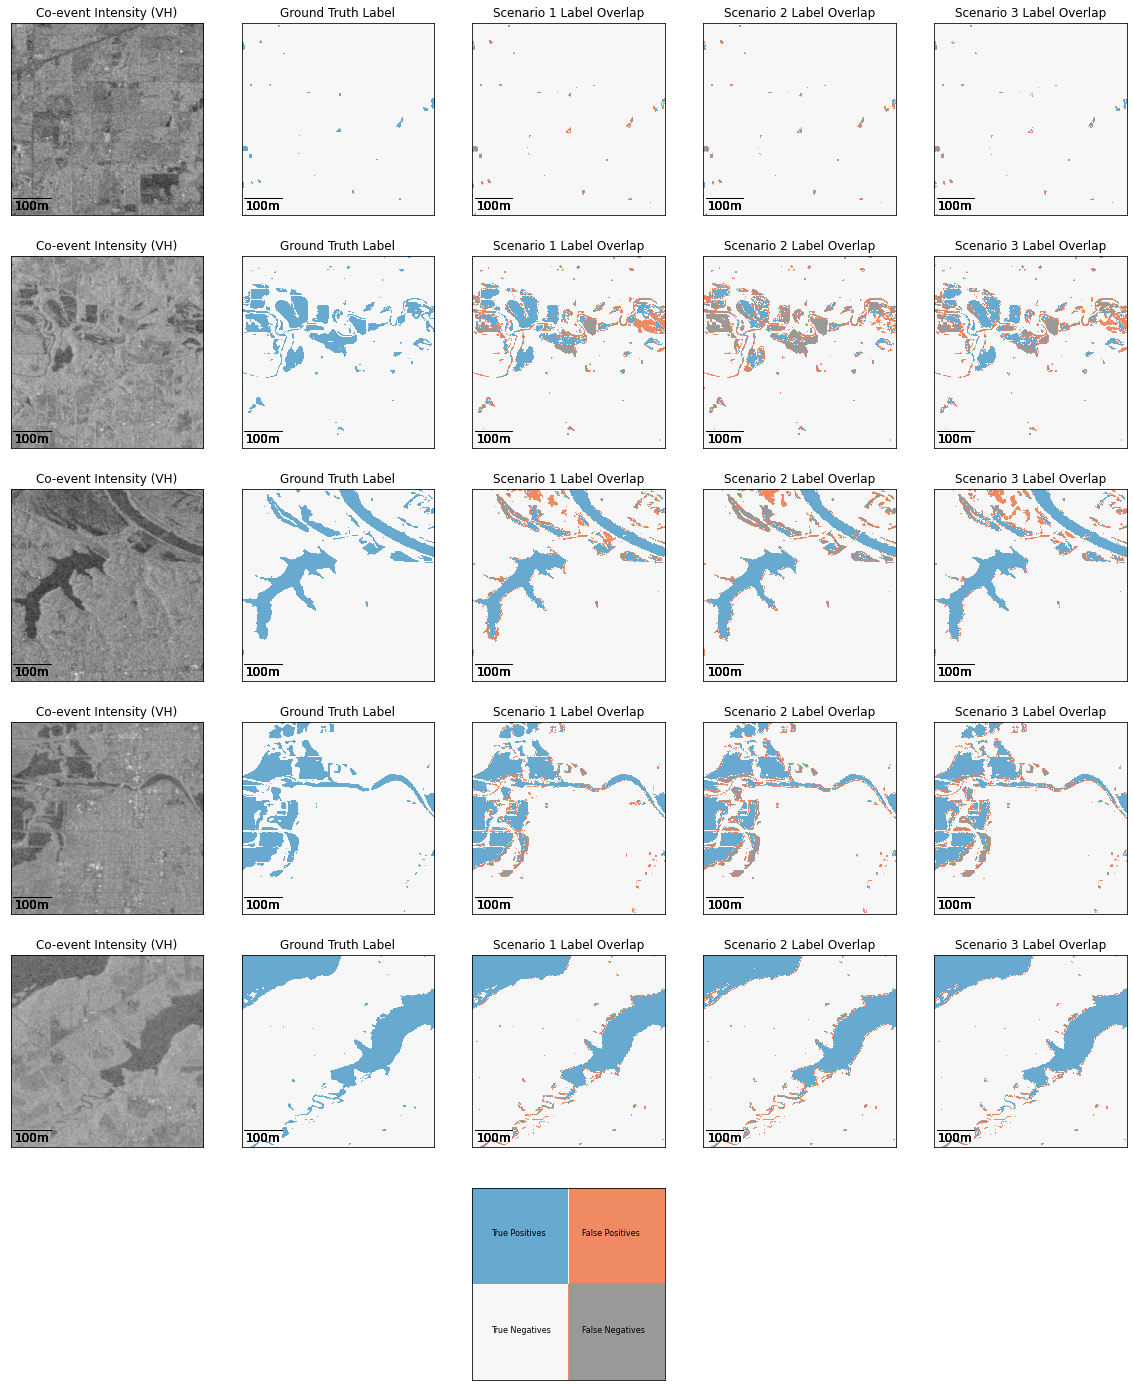

In [32]:
ovrlp_lbl_pth = "ovrlp_lbl_pth"
region = "USA"
fname = f"{ovrlp_lbl_pth}\\attn_unet_{region}_lbl_ovrlp.pdf"

idx_USA = [1, 3, 5, 8, 22]
fig_USA = display_lbl_overlap(Y_true_hand_lbl_by_region,
                              lbl_ovrlap_by_region,
                              X_test_hand_lbl_by_region,
                              num_plot=len(idx_USA),
                              region='USA',
                              indices=idx_USA)

# save
#fig_USA.savefig(fname)

#### Label Overlap for Region: Mekong

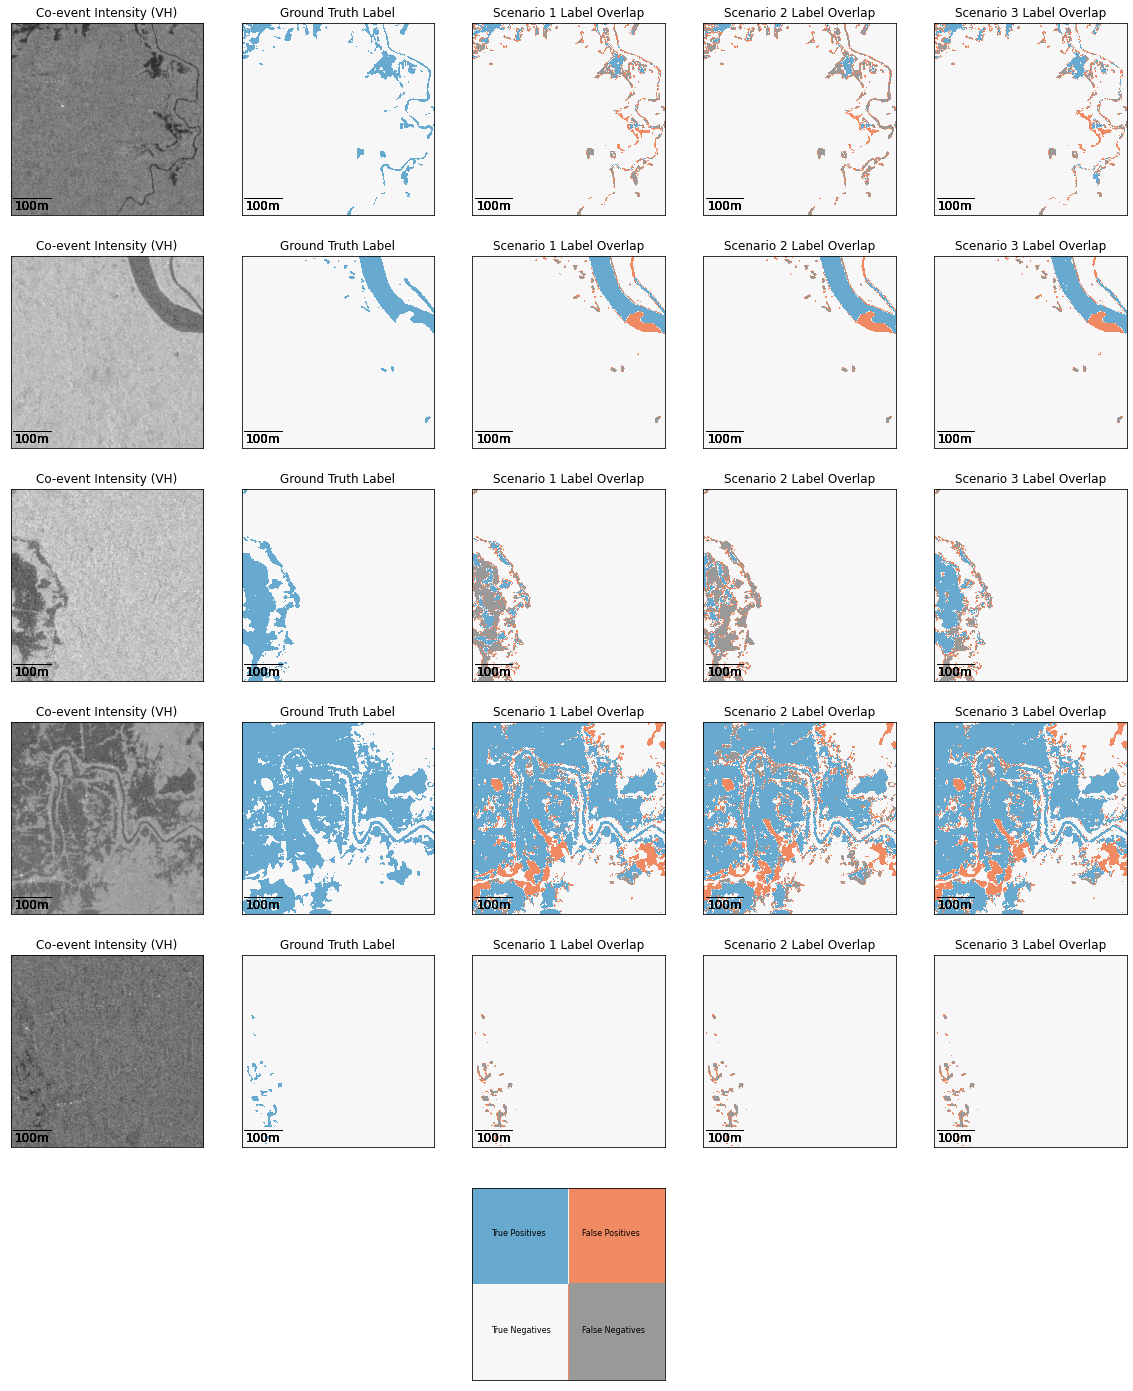

In [33]:
region = "Mekong"
idx_Mekong = [1, 2, 5, 7, 8]
fig_Mekong = display_lbl_overlap(Y_true_hand_lbl_by_region,
                                 lbl_ovrlap_by_region,
                                 X_test_hand_lbl_by_region,
                                 num_plot=len(idx_Mekong),
                                 region=region,
                                 indices=idx_Mekong)

#fname = f"{ovrlp_lbl_pth}\\attn_unet_{region}_lbl_ovrlp.pdf"
#fig_Mekong.savefig(fname)

#### Label Overlap for Region: Bolivia

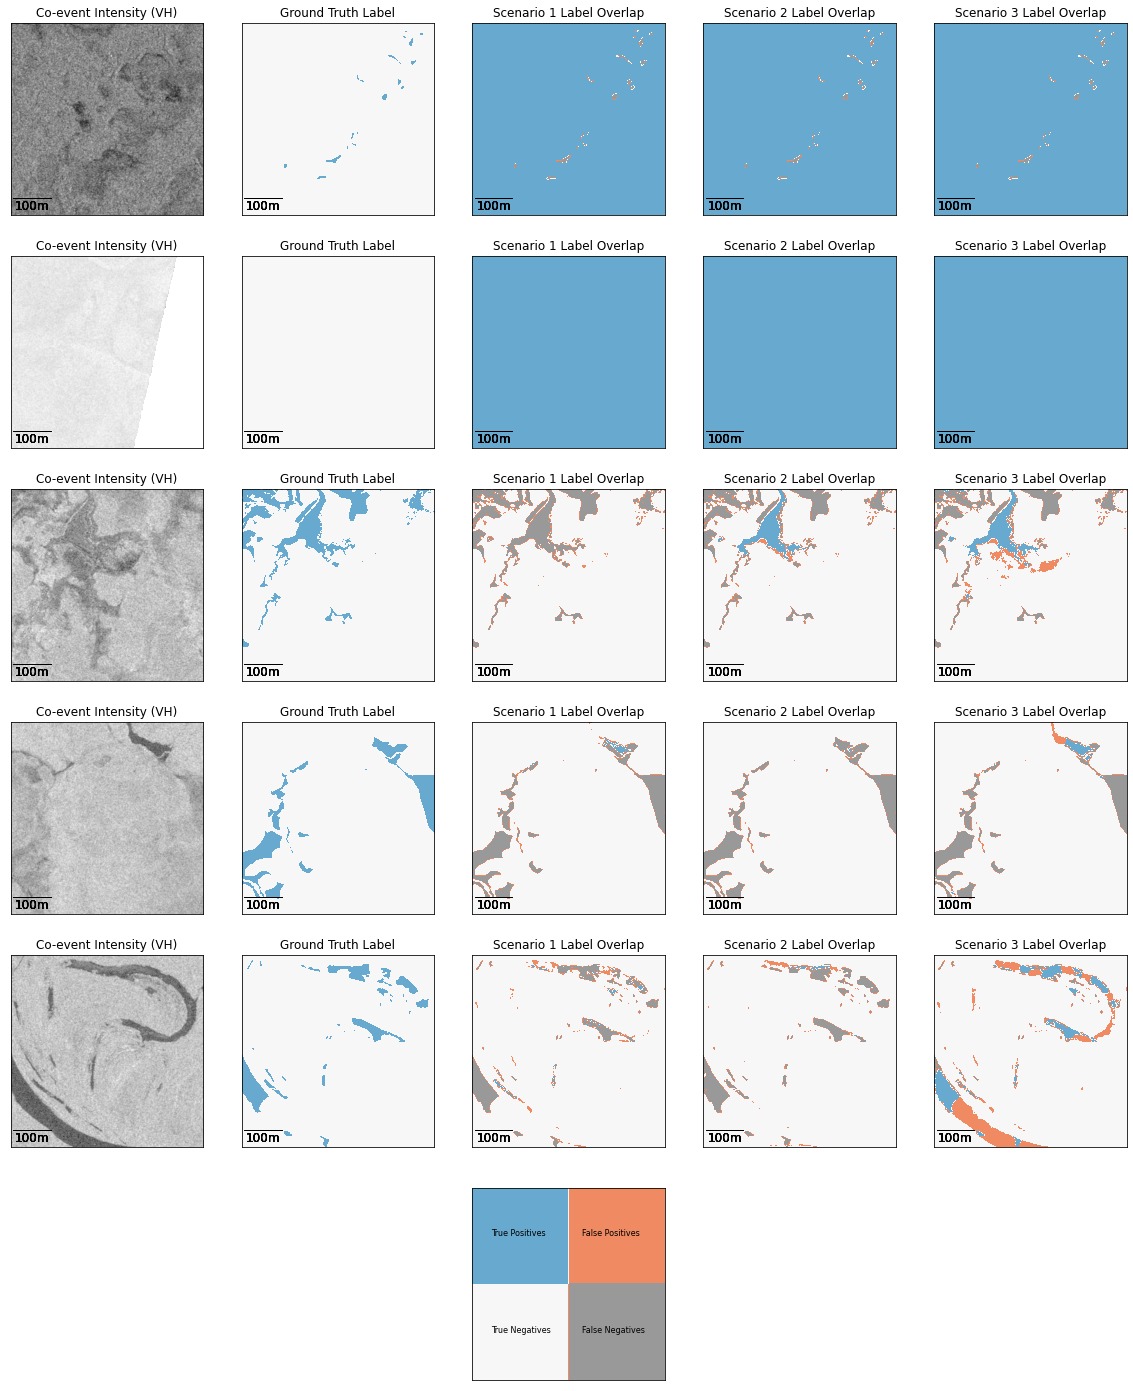

In [34]:
idx_Bolivia = [1, 2, 3, 4, 5]
region = "Bolivia"
fig_Bol = display_lbl_overlap(Y_true_hand_lbl_by_region,
                              lbl_ovrlap_by_region,
                              X_test_hand_lbl_by_region,
                              num_plot=len(idx_Bolivia),
                              region=region,
                              indices=idx_Bolivia)

fname = f"{ovrlp_lbl_pth}\\attn_unet_{region}_lbl_ovrlp.pdf"
#fig_Bol.savefig(fname)

#### Label Overlap for Region: Paraguay

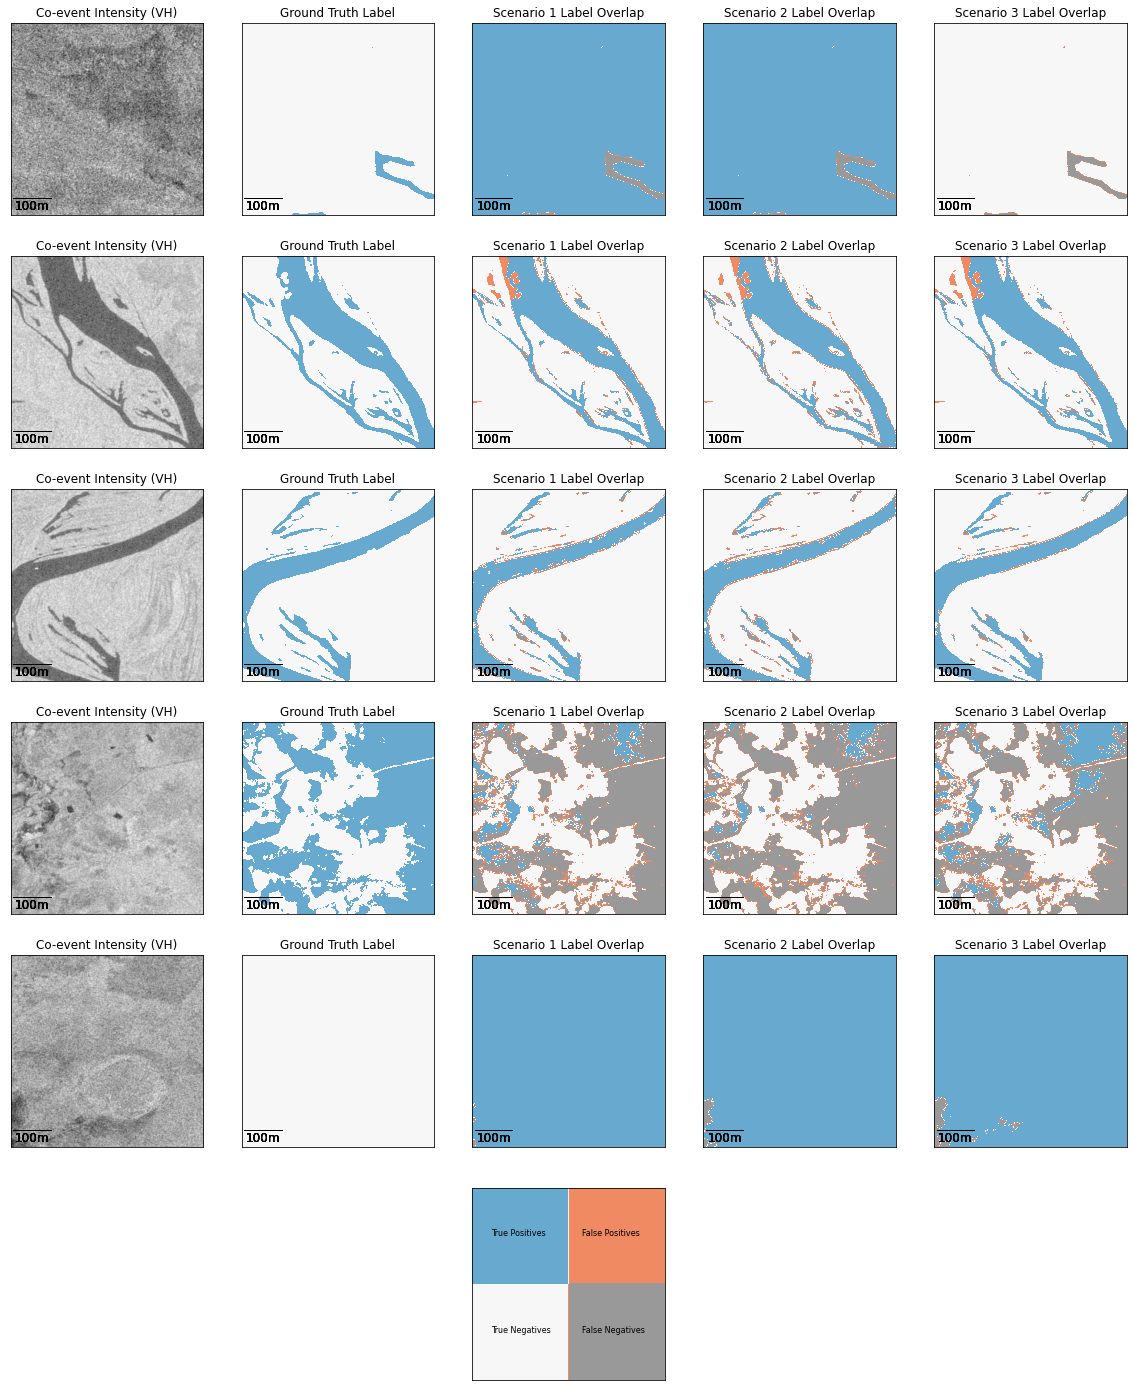

In [35]:
region = 'Paraguay'
idx_Paraguay = [0, 1, 2, 6, 7]
fig_Par = display_lbl_overlap(Y_true_hand_lbl_by_region,
                              lbl_ovrlap_by_region,
                              X_test_hand_lbl_by_region,
                              num_plot=len(idx_Paraguay),
                              region=region,
                              indices=idx_Paraguay)


fname = f"{ovrlp_lbl_pth}\\attn_unet_{region}_lbl_ovrlp.pdf"
#fig_Par.savefig(fname)

#### Label Overlap for Region: India

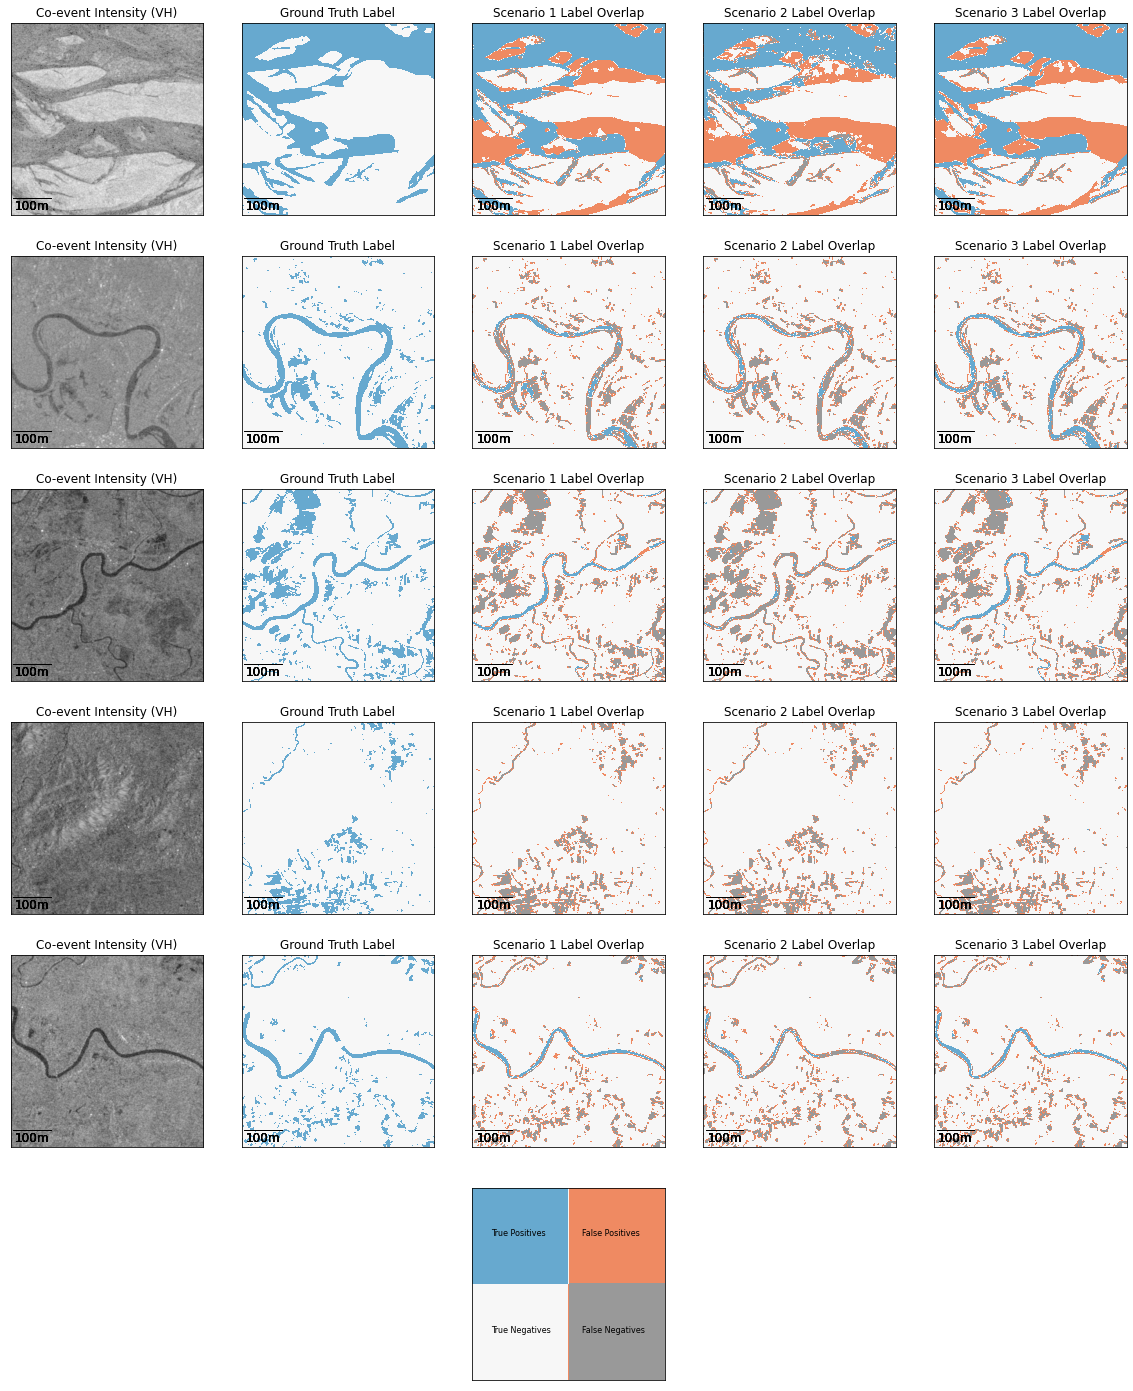

In [36]:
region = "India"
idx_India = [0, 2, 4, 6, 23]
fig_Ind =display_lbl_overlap(Y_true_hand_lbl_by_region,
                             lbl_ovrlap_by_region,
                             X_test_hand_lbl_by_region,
                             num_plot=len(idx_India),
                             region=region,
                             indices=idx_India)

fname = f"{ovrlp_lbl_pth}\\attn_unet_{region}_lbl_ovrlp.pdf"
#fig_Ind.savefig(fname)

#### Label Overlap for Region: Sri-Lanka

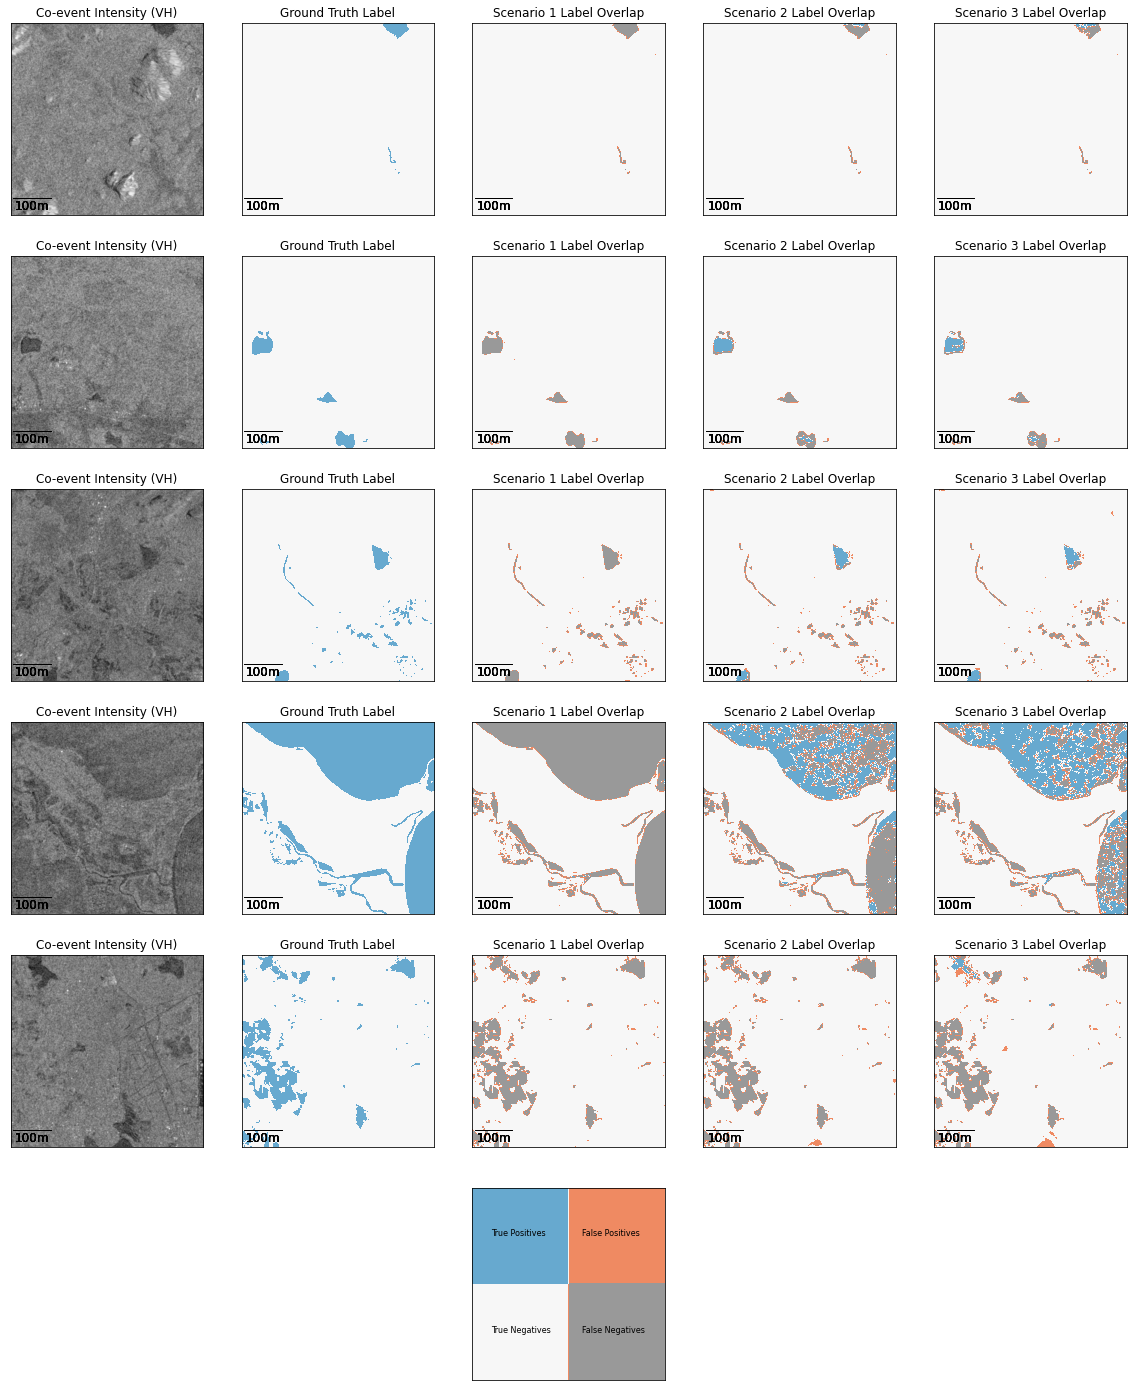

In [37]:
region = "Sri-Lanka"
idx_Sri_Lanka = [8, 9, 11, 16, 21]
fig_Sri = display_lbl_overlap(Y_true_hand_lbl_by_region,
                              lbl_ovrlap_by_region,
                              X_test_hand_lbl_by_region,
                              num_plot=len(idx_Sri_Lanka),
                              region=region,
                              indices=idx_Sri_Lanka)

fname = f"{ovrlp_lbl_pth}\\attn_unet_{region}_lbl_ovrlp.pdf"
#fig_Sri.savefig(fname)

